In [73]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import matplotlib.pyplot as plt
from PySpice.Probe.Plot import plot
import numpy as np

In [61]:
circuit = Circuit('test')

### Voltage source
# pulse_line = circuit.PulseVoltageSource('input', 1, circuit.gnd, initial_value=0, pulsed_value=10@u_V, pulse_width=0.5@u_s, period=5@u_s) # Pulsed supply

### Current source
pulse_line = circuit.PulseCurrentSource('input', 1, circuit.gnd, initial_value=0@u_A, pulsed_value=1@u_A, pulse_width=0.5@u_s, period=1@u_s) # Pulsed supply

# Is this set up correct? Can we display a diagram
circuit.R(1, 1, 2, 1@u_kΩ) # name, node_plus, node_minus, value@unit
circuit.C(1, 1, circuit.gnd, 300@u_μF)
circuit.R(2, 2, circuit.gnd, 1@u_kΩ)
circuit.C(2, 2, circuit.gnd, 100@u_μF)

Capacitor C2

In [62]:
# circuit = Circuit('test')

# ### Voltage source
# # pulse_line = circuit.PulseVoltageSource('input', 1, circuit.gnd, initial_value=0@u_V, pulsed_value=10@u_V, pulse_width=0.5@u_ms, period=5@u_ms) # Pulsed supply

# ### Current source
# pulse_line = circuit.PulseCurrentSource('input', 1, circuit.gnd, initial_value=0.5@u_A, pulsed_value=1@u_A, pulse_width=0.1@u_s, period=1@u_s) # Pulsed supply

# # Is this set up correct? Can we display a diagram
# # circuit.V('input', 1, circuit.gnd, 10@u_V)
# # circuit.I('input', 1, circuit.gnd, 1@u_A)
# circuit.R(1, 1, circuit.gnd, 2@u_kΩ) # name, node_plus, node_minus, value@unit
# circuit.R(2, 1, circuit.gnd, 1@u_kΩ)

In [63]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)

In [64]:
# Current in our circuit. There should be more than one branch, but analysis.branches.values() only has a single entry.
# How does current go to ground if there is a capacitor in between? Surely current is conserved along the branch.

for resistance in (circuit.R1, circuit.R2):
    resistance.minus.add_current_probe(circuit) # to get positive value

analysis = simulator.operating_point()

for node in analysis.nodes.values():
    print('Node {}: {:5.2f} V'.format(str(node), float(node))) # Fixme: format value + unit   
    
for node in analysis.branches.values():
    print('Node {}: {:5.2f} A'.format(str(node), float(node))) # Fixme: format value + unit

Node r2_minus:  0.00 V
Node 2:  0.00 V
Node r1_minus:  0.00 V
Node 1:  0.00 V
Node vr1_minus:  0.00 A
Node vr2_minus:  0.00 A


In [68]:
analysis = simulator.transient(step_time=pulse_line.period/1000, end_time=pulse_line.period*5)
# for node in analysis.branches.values():
#     print('Node {}: {:5.2f} A'.format(str(node), float(node)))

In [69]:
# fig, ax = plt.subplots(1,1, figsize=(12,5))
# for node, waveform in analysis.nodes.items():
#     ax.plot(waveform, label = 'node {}'.format(node))

# ax.legend()
# ax.set(xlabel='Time (s)', ylabel='Voltage (V)');

WaveForm  [0.00000000e+00 3.33322224e-07 3.53034775e-07 ... 6.34803311e-01
 6.33833605e-01 6.33058906e-01]@A

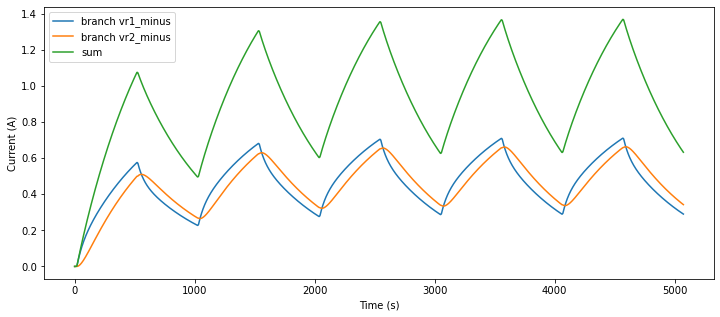

In [86]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
for branch, waveform in analysis.branches.items():
    ax.plot(waveform, label = 'branch {}'.format(branch))

ax.plot(analysis.branches['vr1_minus'] + analysis.branches['vr2_minus'], label='sum')
    
ax.legend()
ax.set(xlabel='Time (s)', ylabel='Current (A)');

* Our pusled source represents a simple day/night boiler heating profile. There is some interesting transient behaviour after the boiler switches off, which we need to investigate. Does not seem to be exponential decay...
* step_time in simulator.transient() could be used to capture heat diffusion through walls, as adjacent nodes should be slightly out of phase.

Currently we are looking at the voltage at each node, we want the current instead. I need to

To do:
1. Verify we have the correct circuit set up, perhaps by finding a way to plot a schematic
2. use circuit.PulseCurrentSource to model heat input DONE
3. There should be a different current going through each node (should there? Verify this), but this simulation says otherwise! Diagnose the problem (with 1.)
4. plot analytic solution to verify result